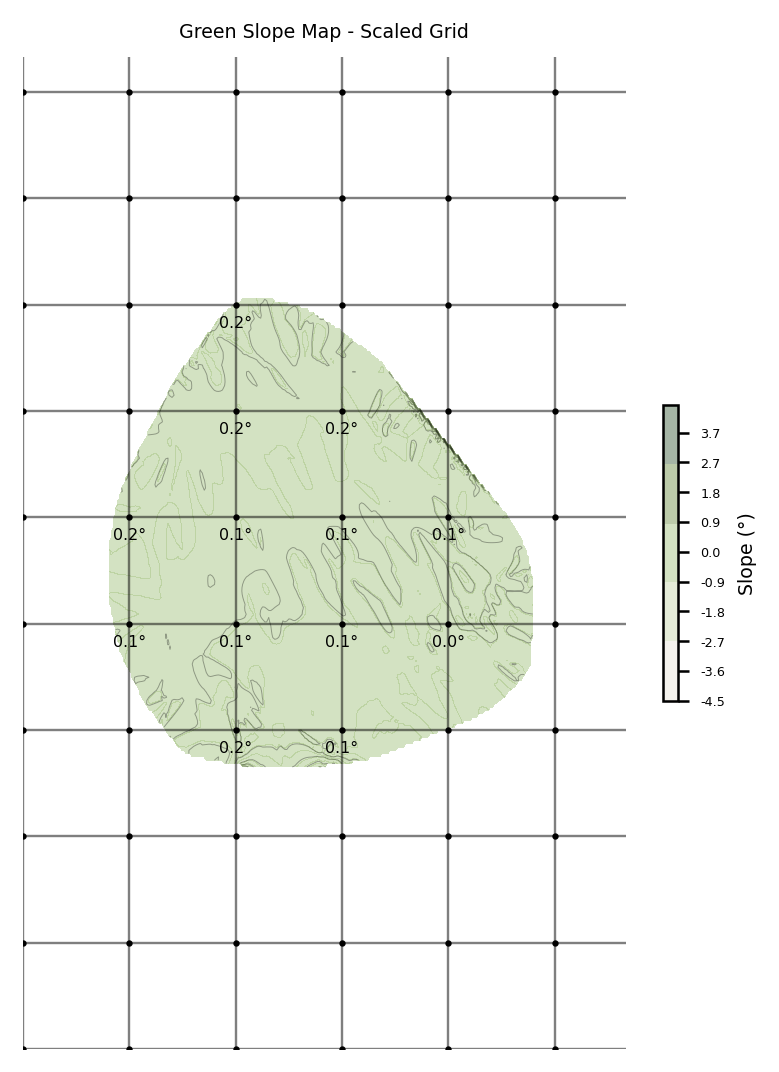

In [30]:
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.colors import ListedColormap, BoundaryNorm

from scipy.interpolate import griddata
from pyproj import Transformer

# Constants
PAGE_WIDTH_INCHES = 4.25
PAGE_HEIGHT_INCHES = 7
GRID_SPACING_INCHES = 0.375
my_dpi = 228.71

GRID_SPACING_METERS = 4.572
METERS_PER_INCH = GRID_SPACING_METERS / GRID_SPACING_INCHES

def parse_gpx(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    namespace = {'default': 'http://www.topografix.com/GPX/1/1'}
    latitudes, longitudes, elevations = [], [], []
    for trkpt in root.findall('.//default:trkpt', namespace):
        lat = float(trkpt.attrib['lat'])
        lon = float(trkpt.attrib['lon'])
        ele_elem = trkpt.find('default:ele', namespace)
        if ele_elem is not None:
            ele = float(ele_elem.text)
            latitudes.append(lat)
            longitudes.append(lon)
            elevations.append(ele)
    return np.array(latitudes), np.array(longitudes), np.array(elevations)

def calculate_slope(grid_y, grid_x, grid_elev):
    dy, dx = np.gradient(grid_elev, np.mean(np.diff(grid_y[:, 0])), np.mean(np.diff(grid_x[0, :])))
    slope_radians = np.arctan(np.sqrt(dx**2 + dy**2))  # in radians
    slope_degrees = np.degrees(slope_radians)         # convert to degrees
    return slope_degrees

from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm

def plot_slope_map(grid_x, grid_y, slope_degrees, page_width_m, page_height_m, zoom_factor):
    
    # Define the custom colormap
    #custom_colors = ['#259c36cc', '#addf17cc', '#dfce17cc']
    #cmap = LinearSegmentedColormap.from_list('custom_earth_tone', custom_colors)
    cmap = ListedColormap(["#eae7dc", "#cddbb3", "#a8c686", "#7b9955", "#4c6d4c"])  # same colors
    fig, ax = plt.subplots(figsize=(PAGE_WIDTH_INCHES, PAGE_HEIGHT_INCHES), dpi=my_dpi)

      # === NEW: black contour lines (on slope field). You can swap slope_degrees for grid_elev if you prefer elevation contours.
    ax.contour(grid_x, grid_y, slope_degrees, levels=np.arange(0.0, 4.6, 0.1),
               colors='black', linewidths=0.3, alpha=0.33)

    # Restrict colormap display to slope range between -4.5 and 4.5 degrees
    levels = np.linspace(-4.5, 4.5, 150)
    slope_plot = ax.contourf(grid_x, grid_y, slope_degrees, cmap=cmap, levels=levels, alpha=.5)

    cbar = plt.colorbar(slope_plot, ax=ax, orientation='vertical', format='%.1f', shrink=0.24)
    cbar.ax.tick_params(labelsize=4)
    cbar.set_label('Slope (°)', fontsize=6)

    ax.set_title('Green Slope Map - Scaled Grid', fontsize=6)
    ax.set_aspect('equal')
    ax.axis('off')

    adjusted_grid_spacing_meters = GRID_SPACING_METERS * zoom_factor
    num_vert_lines = int(page_width_m / adjusted_grid_spacing_meters)
    num_horiz_lines = int(page_height_m / adjusted_grid_spacing_meters)

    for i in range(num_vert_lines + 1):
        x = i * adjusted_grid_spacing_meters
        ax.plot([x, x], [0, page_height_m], color='black', linewidth=0.75, alpha=.5)
    for j in range(num_horiz_lines + 1):
        y = j * adjusted_grid_spacing_meters
        ax.plot([0, page_width_m], [y, y], color='black', linewidth=0.75, alpha=.5)

    for i in range(num_vert_lines + 1):
        for j in range(num_horiz_lines + 1):
            x = i * adjusted_grid_spacing_meters
            y = j * adjusted_grid_spacing_meters
            ax.plot(x, y, 'ko', markersize=1)
            dist = np.sqrt((grid_x - x)**2 + (grid_y - y)**2)
            idx = np.unravel_index(np.argmin(dist), dist.shape)
            slope_val = slope_degrees[idx]
            if not np.isnan(slope_val) and -4.5 <= slope_val <= 4.5:
                ax.text(x, y - adjusted_grid_spacing_meters * 0.1,
                        f'{slope_val:.1f}°', color='black', fontsize=5, ha='center', va='top')

    ax.set_xlim(0, page_width_m)
    ax.set_ylim(0, page_height_m)

    plt.show()


def utm_zone_from_lon(lon):
    return int((lon + 180) / 6) + 1

def main(gpx_file_path):
    zoom_factor = float(input("Enter zoom factor (e.g., 1.0=original, 0.5=zoom out, 2.0=zoom in): "))

    latitudes, longitudes, elevations = parse_gpx(gpx_file_path)
    zone = utm_zone_from_lon(np.mean(longitudes))
    transformer = Transformer.from_crs("epsg:4326", f"epsg:326{zone}", always_xy=True)
    x_m, y_m = transformer.transform(longitudes, latitudes)

    center_x, center_y = np.mean(x_m), np.mean(y_m)
    x_m_zoomed = center_x + (x_m - center_x) * zoom_factor
    y_m_zoomed = center_y + (y_m - center_y) * zoom_factor

    page_width_m = PAGE_WIDTH_INCHES * METERS_PER_INCH
    page_height_m = PAGE_HEIGHT_INCHES * METERS_PER_INCH

    x_min = center_x - page_width_m / 2
    x_max = center_x + page_width_m / 2
    y_min = center_y - page_height_m / 2
    y_max = center_y + page_height_m / 2

    num_points = 300
    grid_x, grid_y = np.meshgrid(
        np.linspace(x_min, x_max, num_points),
        np.linspace(y_min, y_max, num_points)
    )

    grid_elev = griddata((x_m_zoomed, y_m_zoomed), elevations, (grid_x, grid_y), method='cubic')

    slope_degrees = calculate_slope(grid_y, grid_x, grid_elev)

    grid_x_shifted = grid_x - x_min
    grid_y_shifted = grid_y - y_min

    plot_slope_map(grid_x_shifted, grid_y_shifted, slope_degrees, page_width_m, page_height_m, zoom_factor)

# Example usage
gpx_file = '/Users/joshh./Downloads/course_mapping_project/course_data_gpx/tapatioresort_greens/tapatioresort_green_3.gpx'
main(gpx_file)

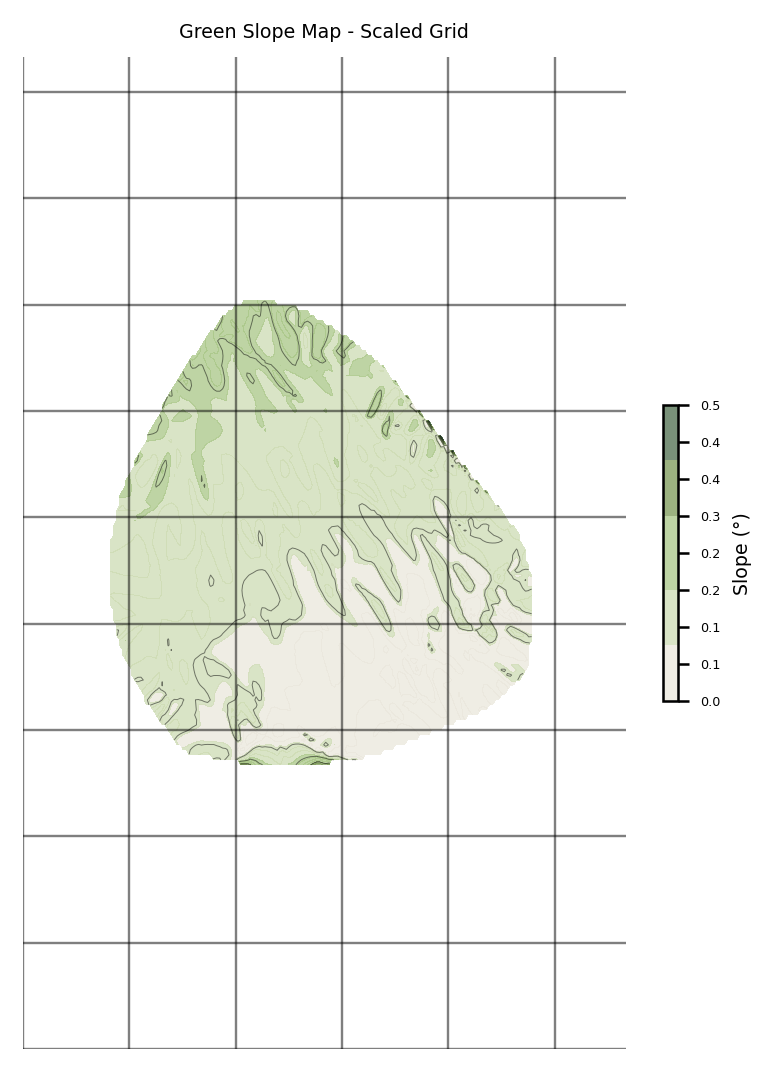

In [31]:
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.colors import ListedColormap, BoundaryNorm

from scipy.interpolate import griddata
from pyproj import Transformer

PAGE_WIDTH_INCHES = 4.25
PAGE_HEIGHT_INCHES = 7
GRID_SPACING_INCHES = 0.375
my_dpi = 228.71

GRID_SPACING_METERS = 4.572
METERS_PER_INCH = GRID_SPACING_METERS / GRID_SPACING_INCHES

def parse_gpx(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    namespace = {'default': 'http://www.topografix.com/GPX/1/1'}
    latitudes, longitudes, elevations = [], [], []
    for trkpt in root.findall('.//default:trkpt', namespace):
        lat = float(trkpt.attrib['lat'])
        lon = float(trkpt.attrib['lon'])
        ele_elem = trkpt.find('default:ele', namespace)
        if ele_elem is not None:
            ele = float(ele_elem.text)
            latitudes.append(lat)
            longitudes.append(lon)
            elevations.append(ele)
    return np.array(latitudes), np.array(longitudes), np.array(elevations)

def calculate_slope_and_aspect(grid_y, grid_x, grid_elev):
    # spacing in meters along Y and X (you already pass physical spacing to np.gradient)
    dy_m = np.mean(np.diff(grid_y[:, 0]))
    dx_m = np.mean(np.diff(grid_x[0, :]))

    # gradients of elevation (dz/dy, dz/dx) -> point UPSLOPE
    dz_dy, dz_dx = np.gradient(grid_elev, dy_m, dx_m)

    # slope magnitude (rise/run) → degrees
    rise_over_run = np.sqrt(dz_dx**2 + dz_dy**2)
    slope_degrees = np.degrees(np.arctan(rise_over_run))

    # aspect (downslope direction): use the NEGATIVE gradient
    aspect_downslope = np.arctan2(-dz_dy, -dz_dx)

    return slope_degrees, aspect_downslope


def plot_slope_map(grid_x, grid_y, slope_degrees, aspect, page_width_m, page_height_m, zoom_factor):
    cmap = ListedColormap(["#eae7dc", "#cddbb3", "#a8c686", "#7b9955", "#4c6d4c"])  # same colors
    fig, ax = plt.subplots(figsize=(PAGE_WIDTH_INCHES, PAGE_HEIGHT_INCHES), dpi=my_dpi)

    # Slope is non-negative; clip/colorbar to your playing range
    #levels = np.linspace(0, 4.5, 200)
    slope_plot = ax.contourf(grid_x, grid_y, slope_degrees, cmap=cmap, levels=15, alpha=.75)

    # === NEW: black contour lines (on slope field). You can swap slope_degrees for grid_elev if you prefer elevation contours.
    ax.contour(grid_x, grid_y, slope_degrees, levels=np.arange(0.0, 4.6, 0.1),
               colors='black', linewidths=0.3, alpha=0.5)

    cbar = plt.colorbar(slope_plot, ax=ax, orientation='vertical', format='%.1f', shrink=0.24)
    cbar.ax.tick_params(labelsize=4)
    cbar.set_label('Slope (°)', fontsize=6)

    ax.set_title('Green Slope Map - Scaled Grid', fontsize=6)
    ax.set_aspect('equal'); ax.axis('off')

    adjusted_grid_spacing_meters = GRID_SPACING_METERS * zoom_factor
    num_vert_lines = int(page_width_m / adjusted_grid_spacing_meters)
    num_horiz_lines = int(page_height_m / adjusted_grid_spacing_meters)

    # grid lines
    for i in range(num_vert_lines + 1):
        x = i * adjusted_grid_spacing_meters
        ax.plot([x, x], [0, page_height_m], color='black', linewidth=0.75, alpha=.5)
    for j in range(num_horiz_lines + 1):
        y = j * adjusted_grid_spacing_meters
        ax.plot([0, page_width_m], [y, y], color='black', linewidth=0.75, alpha=.5)

    ax.set_xlim(0, page_width_m)
    ax.set_ylim(0, page_height_m)
    plt.show()

def utm_zone_from_lon(lon):
    return int((lon + 180) / 6) + 1

def main(gpx_file_path):
    zoom_factor = float(input("Enter zoom factor (e.g., 1.0=original, 0.5=zoom out, 2.0=zoom in): "))

    latitudes, longitudes, elevations = parse_gpx(gpx_file_path)

    if len(longitudes) == 0:
        print("Error: No valid trackpoint data found in GPX file.")
        return

    zone = utm_zone_from_lon(np.mean(longitudes))
    transformer = Transformer.from_crs("epsg:4326", f"epsg:326{zone}", always_xy=True)
    x_m, y_m = transformer.transform(longitudes, latitudes)

    center_x, center_y = np.mean(x_m), np.mean(y_m)
    x_m_zoomed = center_x + (x_m - center_x) * zoom_factor
    y_m_zoomed = center_y + (y_m - center_y) * zoom_factor

    page_width_m = PAGE_WIDTH_INCHES * METERS_PER_INCH
    page_height_m = PAGE_HEIGHT_INCHES * METERS_PER_INCH

    x_min = center_x - page_width_m / 2
    x_max = center_x + page_width_m / 2
    y_min = center_y - page_height_m / 2
    y_max = center_y + page_height_m / 2

    num_points = 200
    grid_x, grid_y = np.meshgrid(
        np.linspace(x_min, x_max, num_points),
        np.linspace(y_min, y_max, num_points)
    )

    grid_elev = griddata((x_m_zoomed, y_m_zoomed), elevations, (grid_x, grid_y), method='cubic')

    slope_degrees, aspect = calculate_slope_and_aspect(grid_y, grid_x, grid_elev)

    grid_x_shifted = grid_x - x_min
    grid_y_shifted = grid_y - y_min

    plot_slope_map(grid_x_shifted, grid_y_shifted, slope_degrees, aspect, page_width_m, page_height_m, zoom_factor)

gpx_file = '/Users/joshh./Downloads/course_mapping_project/course_data_gpx/tapatioresort_greens/tapatioresort_green_3.gpx'
main(gpx_file)


## Code for competition and practice versions of the mapping based on user input is below. 

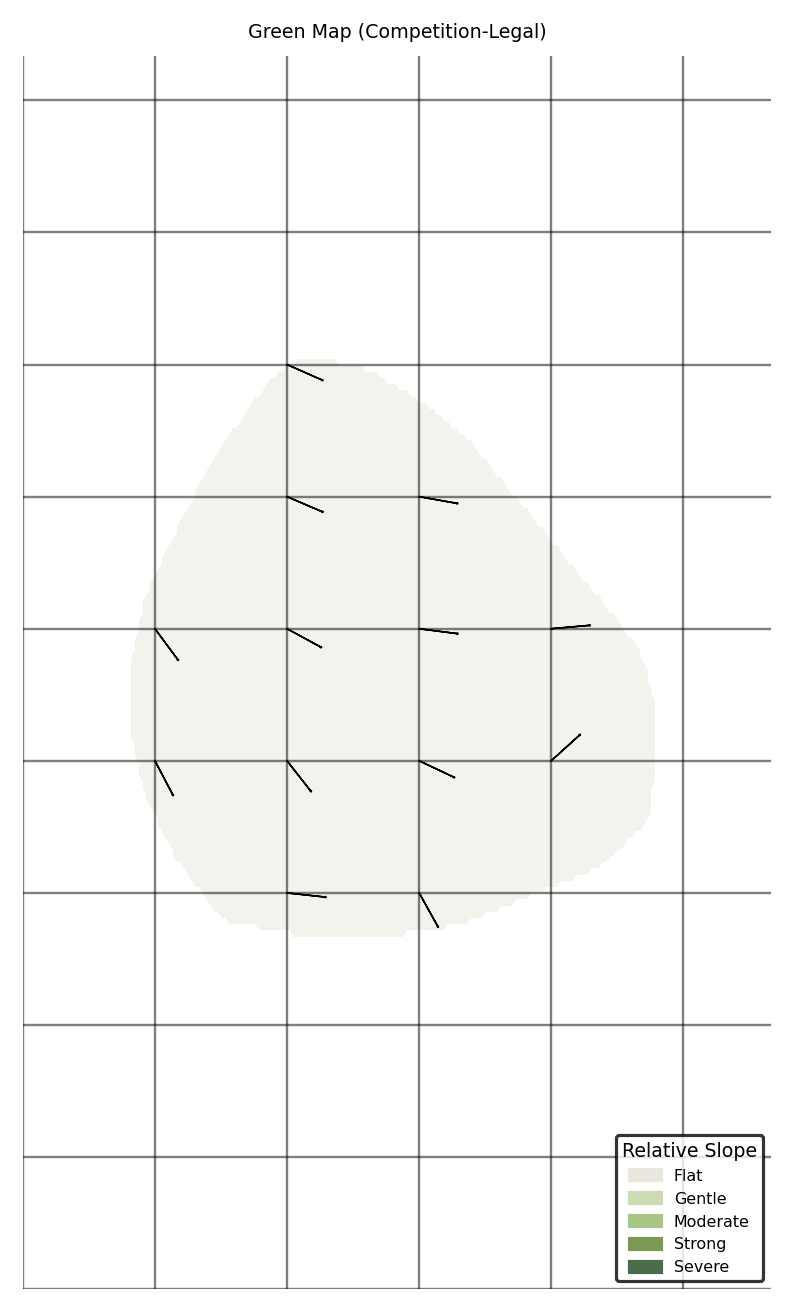

In [29]:


import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy.interpolate import griddata
from pyproj import Transformer

# === PAGE & GRID CONSTANTS (USGA COMPLIANT) ===
PAGE_WIDTH_INCHES = 4.25
PAGE_HEIGHT_INCHES = 7
GRID_SPACING_INCHES = 0.375          # 3/8" = 15 feet scale
my_dpi = 228.71

GRID_SPACING_METERS = 4.572          # 15 feet per grid
METERS_PER_INCH = GRID_SPACING_METERS / GRID_SPACING_INCHES


# === GPX PARSER ===
def parse_gpx(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    namespace = {'default': 'http://www.topografix.com/GPX/1/1'}
    latitudes, longitudes, elevations = [], [], []
    for trkpt in root.findall('.//default:trkpt', namespace):
        lat = float(trkpt.attrib['lat'])
        lon = float(trkpt.attrib['lon'])
        ele_elem = trkpt.find('default:ele', namespace)
        if ele_elem is not None:
            ele = float(ele_elem.text)
            latitudes.append(lat)
            longitudes.append(lon)
            elevations.append(ele)
    return np.array(latitudes), np.array(longitudes), np.array(elevations)


# === SLOPE AND ASPECT (downslope corrected) ===
def calculate_slope_and_aspect(grid_y, grid_x, grid_elev):
    dy_m = np.mean(np.diff(grid_y[:, 0]))
    dx_m = np.mean(np.diff(grid_x[0, :]))
    dz_dy, dz_dx = np.gradient(grid_elev, dy_m, dx_m)
    slope_rise_over_run = np.sqrt(dz_dx**2 + dz_dy**2)
    slope_degrees = np.degrees(np.arctan(slope_rise_over_run))
    aspect_downslope = np.arctan2(-dz_dy, -dz_dx)
    return slope_degrees, aspect_downslope


# === PRACTICE MAP (detailed slope display) ===
def plot_slope_map_practice(grid_x, grid_y, slope_degrees, aspect,
                            page_width_m, page_height_m, zoom_factor):
    fig, ax = plt.subplots(figsize=(PAGE_WIDTH_INCHES, PAGE_HEIGHT_INCHES), dpi=my_dpi)

    # --- match competition-legal greens ---
    slope_capped = np.clip(slope_degrees, 0.0, 4.0)   # keep within legal band
    bounds = np.array([0.0, 1.0, 2.0, 3.0, 4.5])           # same bins as legal
    cmap = ListedColormap(["#eae7dc", "#cddbb3", "#a8c686", "#7b9955", "#4c6d4c"])  # same colors
    norm = BoundaryNorm(bounds, len(bounds) - 1)

    # Discrete fill (same look as legal)
    slope_plot = ax.contourf(
        grid_x, grid_y, slope_capped,
        levels=bounds, cmap=cmap, norm=norm, alpha=0.55
    )

    # Optional: black contour lines (keep if you like)
    ax.contour(grid_x, grid_y, slope_capped,
               levels=bounds, colors='black', linewidths=0.3, alpha=0.5)

    # Practice mode can keep a labeled colorbar
    cbar = plt.colorbar(slope_plot, ax=ax, orientation='vertical', shrink=0.24)
    cbar.set_label('Slope (°)', fontsize=6)
    cbar.set_ticks(bounds)
    cbar.ax.tick_params(labelsize=5)

    ax.set_title('Green Slope Map (Practice Mode)', fontsize=6)
    ax.set_aspect('equal')
    ax.axis('off')

    adjusted_grid_spacing_meters = GRID_SPACING_METERS * zoom_factor
    num_vert_lines = int(page_width_m / adjusted_grid_spacing_meters)
    num_horiz_lines = int(page_height_m / adjusted_grid_spacing_meters)

    # Draw grid
    for i in range(num_vert_lines + 1):
        x = i * adjusted_grid_spacing_meters
        ax.plot([x, x], [0, page_height_m], color='black', linewidth=0.75, alpha=.5)
    for j in range(num_horiz_lines + 1):
        y = j * adjusted_grid_spacing_meters
        ax.plot([0, page_width_m], [y, y], color='black', linewidth=0.75, alpha=.5)

    # Downslope arrows with slope text
    for i in range(num_vert_lines + 1):
        for j in range(num_horiz_lines + 1):
            x = i * adjusted_grid_spacing_meters
            y = j * adjusted_grid_spacing_meters
            dist = np.sqrt((grid_x - x)**2 + (grid_y - y)**2)
            idx = np.unravel_index(np.argmin(dist), dist.shape)
            slope_val = slope_degrees[idx]
            aspect_val = aspect[idx]  # assumed radians

            if not np.isnan(slope_val) and 0.0 <= slope_val <= 4.5:
                L = 0.35 * adjusted_grid_spacing_meters

                # Flip 180° so arrows point the opposite way (downslope)
                dx_arrow = -np.cos(aspect_val) * L
                dy_arrow = -np.sin(aspect_val) * L

                ax.arrow(
                    x, y, dx_arrow, dy_arrow,
                    head_width=0.5, head_length=0.12,
                    fc='black', ec='black',
                    linewidth=0.5,
                    length_includes_head=True
                )
                ax.text(
                    x,
                    y - adjusted_grid_spacing_meters * 0.10,
                    f'{slope_val:.1f}°',
                    color='black', fontsize=4,
                    ha='center', va='top'
                )

    ax.set_xlim(0, page_width_m)
    ax.set_ylim(0, page_height_m)
    plt.show()


# === COMPETITION-LEGAL VERSION (USGA COMPLIANT) ===
def plot_slope_map_legal(grid_x, grid_y, slope_degrees, aspect, page_width_m, page_height_m,
                         zoom_factor, elevation_for_contours, contour_step_ft=1.0,
                         arrow_len_frac=0.30, show_colorbar=False):
    fig, ax = plt.subplots(figsize=(PAGE_WIDTH_INCHES, PAGE_HEIGHT_INCHES), dpi=my_dpi)

    # Coarse slope shading capped at 4°
    slope_capped = np.clip(slope_degrees, 0.0, 4.5)
    bounds = np.array([0.0, 1.0, 2.0, 3.0, 4.5])
    cmap = ListedColormap(["#eae7dc", "#cddbb3", "#a8c686", "#7b9955", "#4c6d4c"])
    norm = BoundaryNorm(bounds, len(bounds) - 1)
    shade = ax.contourf(grid_x, grid_y, slope_capped, levels=bounds, cmap=cmap, norm=norm, alpha=0.5)

    if show_colorbar:
        cbar = plt.colorbar(shade, ax=ax, orientation='vertical', shrink=0.28)
        cbar.set_ticks([])
        cbar.set_label('Relative Slope Bands', fontsize=6)

    # Black elevation contours spaced ≥ 1 ft
    ft_to_m = 0.3048
    step_m = max(contour_step_ft, 1.0) * ft_to_m
    vmin, vmax = np.nanmin(elevation_for_contours), np.nanmax(elevation_for_contours)
    start = np.floor(vmin / step_m) * step_m
    levels_m = np.arange(start, vmax + step_m, step_m)

    ax.contour(grid_x, grid_y, elevation_for_contours,
               levels=levels_m, colors='black', linewidths=0.35, alpha=0.8)

    # Draw page grid
    adjusted_grid_spacing_meters = GRID_SPACING_METERS * zoom_factor
    num_vert_lines = int(page_width_m / adjusted_grid_spacing_meters)
    num_horiz_lines = int(page_height_m / adjusted_grid_spacing_meters)

    for i in range(num_vert_lines + 1):
        x = i * adjusted_grid_spacing_meters
        ax.plot([x, x], [0, page_height_m], color='black', linewidth=0.75, alpha=.5)
    for j in range(num_horiz_lines + 1):
        y = j * adjusted_grid_spacing_meters
        ax.plot([0, page_width_m], [y, y], color='black', linewidth=0.75, alpha=.5)

# Downslope arrows only
    for i in range(num_vert_lines + 1):
        for j in range(num_horiz_lines + 1):
            x = i * adjusted_grid_spacing_meters
            y = j * adjusted_grid_spacing_meters

            # nearest grid cell
            dist = np.sqrt((grid_x - x)**2 + (grid_y - y)**2)
            idx = np.unravel_index(np.argmin(dist), dist.shape)

            slope_val = slope_capped[idx]
            aspect_val = aspect[idx]   # MUST be radians

            if not np.isnan(slope_val) and slope_val >= 0.0:
                L = arrow_len_frac * adjusted_grid_spacing_meters

                # Flip uphill aspect → downslope (add π)
                dx = -np.cos(aspect_val) * L
                dy = -np.sin(aspect_val) * L

                ax.arrow(
                    x, y, dx, dy,
                    head_width=0.10, head_length=0.10,
                    fc='black', ec='black',
                    linewidth=0.5,
                    length_includes_head=True
                )

    ax.set_xlim(0, page_width_m)
    ax.set_ylim(0, page_height_m)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title('Green Map (Competition-Legal)', fontsize=6)
    from matplotlib.patches import Patch
    legend_colors = ["#eae7dc", "#cddbb3", "#a8c686", "#7b9955", "#4c6d4c"] #legend_colors = ["#0099ff", "#00ff99", "#ffff00", "#ff9900", "#ff0000"]
    legend_labels = ["Flat", "Gentle", "Moderate", "Strong", "Severe"]
    legend_patches = [Patch(color=c, label=l) for c, l in zip(legend_colors, legend_labels)]
    ax.legend(
        handles=legend_patches,
        title="Relative Slope",
        loc="lower right",
        fontsize=5,
        title_fontsize=6,
        frameon=True,
        edgecolor='black'
    )
    plt.show()


# === COORDINATE SYSTEM UTILITIES ===
def utm_zone_from_lon(lon):
    return int((lon + 180) / 6) + 1


# === MAIN FUNCTION ===
def main(gpx_file_path, competition_legal=False):
    zoom_factor = float(input("Enter zoom factor (e.g., 1.0=original, 0.5=zoom out, 2.0=zoom in): "))

    latitudes, longitudes, elevations = parse_gpx(gpx_file_path)
    if len(longitudes) == 0:
        print("Error: No valid trackpoint data found in GPX file.")
        return

    zone = utm_zone_from_lon(np.mean(longitudes))
    transformer = Transformer.from_crs("epsg:4326", f"epsg:326{zone}", always_xy=True)
    x_m, y_m = transformer.transform(longitudes, latitudes)

    center_x, center_y = np.mean(x_m), np.mean(y_m)
    x_m_zoomed = center_x + (x_m - center_x) * zoom_factor
    y_m_zoomed = center_y + (y_m - center_y) * zoom_factor

    page_width_m = PAGE_WIDTH_INCHES * METERS_PER_INCH
    page_height_m = PAGE_HEIGHT_INCHES * METERS_PER_INCH

    x_min = center_x - page_width_m / 2
    x_max = center_x + page_width_m / 2
    y_min = center_y - page_height_m / 2
    y_max = center_y + page_height_m / 2

    num_points = 200
    grid_x, grid_y = np.meshgrid(
        np.linspace(x_min, x_max, num_points),
        np.linspace(y_min, y_max, num_points)
    )

    grid_elev = griddata((x_m_zoomed, y_m_zoomed), elevations, (grid_x, grid_y), method='cubic')
    slope_degrees, aspect = calculate_slope_and_aspect(grid_y, grid_x, grid_elev)
    grid_x_shifted = grid_x - x_min
    grid_y_shifted = grid_y - y_min

    if competition_legal:
        plot_slope_map_legal(grid_x_shifted, grid_y_shifted, slope_degrees, aspect,
                             page_width_m, page_height_m, zoom_factor,
                             elevation_for_contours=grid_elev, contour_step_ft=1.0)
    else:
        plot_slope_map_practice(grid_x_shifted, grid_y_shifted, slope_degrees, aspect,
                                page_width_m, page_height_m, zoom_factor)


# === ENTRY POINT ===
if __name__ == "__main__":
    gpx_file = "/Users/joshh./Downloads/course_mapping_project/course_data_gpx/tapatioresort_greens/tapatioresort_green_3.gpx"  # replace with your GPX path
    legal_mode = input("Competition legal mode? (y/n): ").strip().lower() == "y"
    main(gpx_file, competition_legal=legal_mode)


GeoJSON written: /Users/joshh./Downloads/course_mapping_project/green_geojson/tapatio/tapgreen_9_slope.geojson


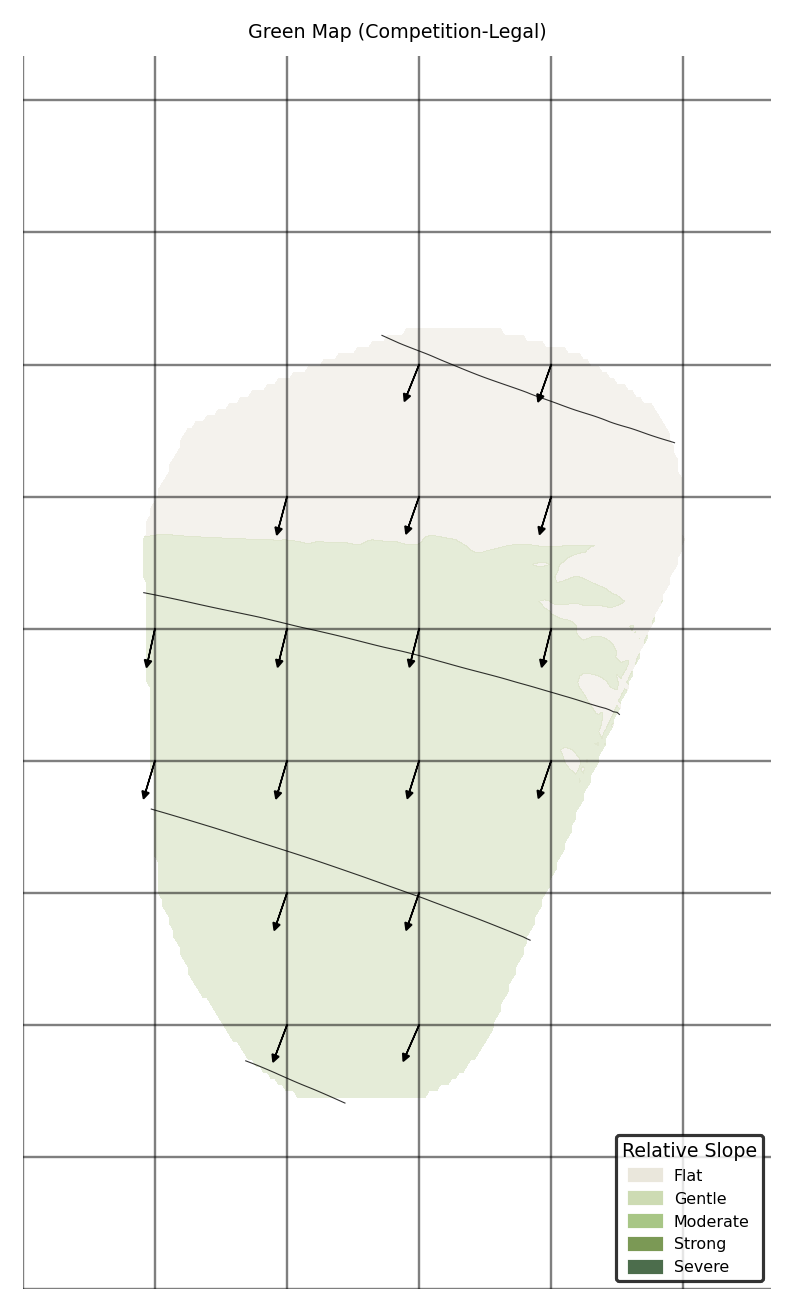

In [37]:
#This block generates the geojson to add to the app. Only run when you want to update the app.

import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch
from scipy.interpolate import griddata
from pyproj import Transformer
import json
from math import cos, sin

# === PAGE & GRID CONSTANTS (USGA COMPLIANT) ===
PAGE_WIDTH_INCHES = 4.25
PAGE_HEIGHT_INCHES = 7
GRID_SPACING_INCHES = 0.375          # 3/8" = 15 feet scale
my_dpi = 228.71

GRID_SPACING_METERS = 4.572          # 15 feet per grid
METERS_PER_INCH = GRID_SPACING_METERS / GRID_SPACING_INCHES


# === GPX PARSER ===
def parse_gpx(file_path):
    tree = ET.parse(file_path)
    root = tree.getroot()
    namespace = {'default': 'http://www.topografix.com/GPX/1/1'}
    latitudes, longitudes, elevations = [], [], []
    for trkpt in root.findall('.//default:trkpt', namespace):
        lat = float(trkpt.attrib['lat'])
        lon = float(trkpt.attrib['lon'])
        ele_elem = trkpt.find('default:ele', namespace)
        if ele_elem is not None:
            ele = float(ele_elem.text)
            latitudes.append(lat)
            longitudes.append(lon)
            elevations.append(ele)
    return np.array(latitudes), np.array(longitudes), np.array(elevations)


# === SLOPE AND ASPECT (downslope corrected) ===
def calculate_slope_and_aspect(grid_y, grid_x, grid_elev):
    dy_m = np.mean(np.diff(grid_y[:, 0]))
    dx_m = np.mean(np.diff(grid_x[0, :]))
    dz_dy, dz_dx = np.gradient(grid_elev, dy_m, dx_m)
    slope_rise_over_run = np.sqrt(dz_dx**2 + dz_dy**2)
    slope_degrees = np.degrees(np.arctan(slope_rise_over_run))
    aspect_downslope = np.arctan2(-dz_dy, -dz_dx)
    return slope_degrees, aspect_downslope


# === PRACTICE MAP (detailed slope display) ===
def plot_slope_map_practice(grid_x, grid_y, slope_degrees, aspect,
                            page_width_m, page_height_m, zoom_factor):
    fig, ax = plt.subplots(figsize=(PAGE_WIDTH_INCHES, PAGE_HEIGHT_INCHES), dpi=my_dpi)

    # --- match competition-legal greens ---
    slope_capped = np.clip(slope_degrees, 0.0, 4.0)   # keep within legal band
    bounds = np.array([0.0, 1.0, 2.0, 3.0, 4.5])      # same bins as legal
    cmap = ListedColormap(["#eae7dc", "#cddbb3", "#a8c686", "#7b9955", "#4c6d4c"])  # same colors
    norm = BoundaryNorm(bounds, len(bounds) - 1)

    # Discrete fill (same look as legal)
    slope_plot = ax.contourf(
        grid_x, grid_y, slope_capped,
        levels=bounds, cmap=cmap, norm=norm, alpha=0.55
    )

    # Optional: black contour lines (keep if you like)
    ax.contour(grid_x, grid_y, slope_capped,
               levels=bounds, colors='black', linewidths=0.3, alpha=0.5)

    # Practice mode can keep a labeled colorbar
    cbar = plt.colorbar(slope_plot, ax=ax, orientation='vertical', shrink=0.24)
    cbar.set_label('Slope (°)', fontsize=6)
    cbar.set_ticks(bounds)
    cbar.ax.tick_params(labelsize=5)

    ax.set_title('Green Slope Map (Practice Mode)', fontsize=6)
    ax.set_aspect('equal')
    ax.axis('off')

    adjusted_grid_spacing_meters = GRID_SPACING_METERS * zoom_factor
    num_vert_lines = int(page_width_m / adjusted_grid_spacing_meters)
    num_horiz_lines = int(page_height_m / adjusted_grid_spacing_meters)

    # Draw grid
    for i in range(num_vert_lines + 1):
        x = i * adjusted_grid_spacing_meters
        ax.plot([x, x], [0, page_height_m], color='black', linewidth=0.75, alpha=.5)
    for j in range(num_horiz_lines + 1):
        y = j * adjusted_grid_spacing_meters
        ax.plot([0, page_width_m], [y, y], color='black', linewidth=0.75, alpha=.5)

    # Downslope arrows with slope text
    for i in range(num_vert_lines + 1):
        for j in range(num_horiz_lines + 1):
            x = i * adjusted_grid_spacing_meters
            y = j * adjusted_grid_spacing_meters
            dist = np.sqrt((grid_x - x)**2 + (grid_y - y)**2)
            idx = np.unravel_index(np.argmin(dist), dist.shape)
            slope_val = slope_degrees[idx]
            aspect_val = aspect[idx]  # assumed to be in radians

            if not np.isnan(slope_val) and 0.0 <= slope_val <= 4.5:
                L = 0.35 * adjusted_grid_spacing_meters

                # Flip arrow 180° to point the opposite way (downslope vs upslope)
                dx_arrow = -np.cos(aspect_val) * L
                dy_arrow = -np.sin(aspect_val) * L
                # alternatively: use (aspect_val + np.pi), same effect

                ax.arrow(
                    x, y, dx_arrow, dy_arrow,
                    head_width=0.12, head_length=0.12,
                    fc='black', ec='black', linewidth=0.5,
                    length_includes_head=True
                )
                ax.text(
                    x, y - adjusted_grid_spacing_meters * 0.10,
                    f'{slope_val:.1f}°',
                    color='black', fontsize=4, ha='center', va='top'
                )


    ax.set_xlim(0, page_width_m)
    ax.set_ylim(0, page_height_m)
    plt.show()


# === COMPETITION-LEGAL VERSION (USGA COMPLIANT) ===
def plot_slope_map_legal(grid_x, grid_y, slope_degrees, aspect, page_width_m, page_height_m,
                         zoom_factor, elevation_for_contours, contour_step_ft=1.0,
                         arrow_len_frac=0.30, show_colorbar=False):
    fig, ax = plt.subplots(figsize=(PAGE_WIDTH_INCHES, PAGE_HEIGHT_INCHES), dpi=my_dpi)

    # Coarse slope shading capped at 4°
    slope_capped = np.clip(slope_degrees, 0.0, 4.5)
    bounds = np.array([0.0, 1.0, 2.0, 3.0, 4.5])
    cmap = ListedColormap(["#eae7dc", "#cddbb3", "#a8c686", "#7b9955", "#4c6d4c"])
    norm = BoundaryNorm(bounds, len(bounds) - 1)
    shade = ax.contourf(grid_x, grid_y, slope_capped, levels=bounds, cmap=cmap, norm=norm, alpha=0.5)

    if show_colorbar:
        cbar = plt.colorbar(shade, ax=ax, orientation='vertical', shrink=0.28)
        cbar.set_ticks([])
        cbar.set_label('Relative Slope Bands', fontsize=6)

    # Black elevation contours spaced ≥ 1 ft
    ft_to_m = 0.3048
    step_m = max(contour_step_ft, 1.0) * ft_to_m
    vmin, vmax = np.nanmin(elevation_for_contours), np.nanmax(elevation_for_contours)
    start = np.floor(vmin / step_m) * step_m
    levels_m = np.arange(start, vmax + step_m, step_m)

    ax.contour(grid_x, grid_y, elevation_for_contours,
               levels=levels_m, colors='black', linewidths=0.35, alpha=0.8)

    # Draw page grid
    adjusted_grid_spacing_meters = GRID_SPACING_METERS * zoom_factor
    num_vert_lines = int(page_width_m / adjusted_grid_spacing_meters)
    num_horiz_lines = int(page_height_m / adjusted_grid_spacing_meters)

    for i in range(num_vert_lines + 1):
        x = i * adjusted_grid_spacing_meters
        ax.plot([x, x], [0, page_height_m], color='black', linewidth=0.75, alpha=.5)
    for j in range(num_horiz_lines + 1):
        y = j * adjusted_grid_spacing_meters
        ax.plot([0, page_width_m], [y, y], color='black', linewidth=0.75, alpha=.5)

    # Downslope arrows only
# Downslope arrows only
    for i in range(num_vert_lines + 1):
        for j in range(num_horiz_lines + 1):
            x = i * adjusted_grid_spacing_meters
            y = j * adjusted_grid_spacing_meters
            dist = np.sqrt((grid_x - x)**2 + (grid_y - y)**2)
            idx = np.unravel_index(np.argmin(dist), dist.shape)
            slope_val = slope_capped[idx]
            aspect_val = aspect[idx]

            if not np.isnan(slope_val) and slope_val >= 0.0:
                L = arrow_len_frac * adjusted_grid_spacing_meters

                # Flip direction (add π radians) for opposite direction:
                dx = -np.cos(aspect_val) * L
                dy = -np.sin(aspect_val) * L
                # equivalently: aspect_val + np.pi, but this is simpler.

                ax.arrow(
                    x, y, dx, dy,
                    head_width=0.5, head_length=0.5,
                    fc='black', ec='black',
                    linewidth=0.5, length_includes_head=True
                )


    ax.set_xlim(0, page_width_m)
    ax.set_ylim(0, page_height_m)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title('Green Map (Competition-Legal)', fontsize=6)

    legend_colors = ["#eae7dc", "#cddbb3", "#a8c686", "#7b9955", "#4c6d4c"]
    legend_labels = ["Flat", "Gentle", "Moderate", "Strong", "Severe"]
    legend_patches = [Patch(color=c, label=l) for c, l in zip(legend_colors, legend_labels)]
    ax.legend(
        handles=legend_patches,
        title="Relative Slope",
        loc="lower right",
        fontsize=5,
        title_fontsize=6,
        frameon=True,
        edgecolor='black'
    )
    plt.show()


# === COORDINATE SYSTEM UTILITIES ===
def utm_zone_from_lon(lon):
    return int((lon + 180) / 6) + 1


# === GEOJSON HELPERS ===
def lonlat_from_xy(x, y, transformer_inv):
    """Vectorized transform UTM meters -> lon/lat (EPSG:4326)."""
    lon, lat = transformer_inv.transform(x, y)
    return lon, lat

def feature_point(lon, lat, props):
    return {
        "type": "Feature",
        "geometry": {"type": "Point", "coordinates": [float(lon), float(lat)]},
        "properties": props
    }

def feature_linestring(coords_lonlat, props):
    return {
        "type": "Feature",
        "geometry": {
            "type": "LineString",
            "coordinates": [[float(lo), float(la)] for lo, la in coords_lonlat]
        },
        "properties": props
    }

def build_point_grid_features(grid_x_abs, grid_y_abs, grid_elev, slope_deg, aspect,
                              transformer_inv, stride=3):
    """
    Export a decimated grid as Point features with attributes.
    Uses ABSOLUTE grid (in projected meters) for correct lon/lat.
    """
    feats = []
    ny, nx = grid_x_abs.shape
    for j in range(0, ny, stride):
        for i in range(0, nx, stride):
            z = grid_elev[j, i]
            s = slope_deg[j, i]
            a = aspect[j, i]
            if np.isnan(z) or np.isnan(s) or np.isnan(a):
                continue
            lon, lat = lonlat_from_xy(grid_x_abs[j, i], grid_y_abs[j, i], transformer_inv)
            feats.append(feature_point(lon, lat, {
                "elevation_m": float(z),
                "slope_deg": float(s),
                "aspect_rad": float(a)
            }))
    return feats

def build_arrow_features(page_grid_x_local, page_grid_y_local, slope_deg, aspect,
                         page_width_m, page_height_m, adjusted_grid_spacing_meters,
                         transformer_inv, x_origin_abs, y_origin_abs,
                         arrow_len_frac=0.30, slope_cap=4.5):
    """
    Recreate page-grid arrows as short LineStrings in lon/lat.
    page_grid_* are in page-local meters (0..page dim). We shift by (x_origin_abs,y_origin_abs)
    to convert to absolute projected meters before transforming to lon/lat.
    """
    feats = []
    num_vert_lines = int(page_width_m / adjusted_grid_spacing_meters)
    num_horiz_lines = int(page_height_m / adjusted_grid_spacing_meters)

    for i in range(num_vert_lines + 1):
        for j in range(num_horiz_lines + 1):
            x = i * adjusted_grid_spacing_meters
            y = j * adjusted_grid_spacing_meters
            dist = np.sqrt((page_grid_x_local - x)**2 + (page_grid_y_local - y)**2)
            jj, ii = np.unravel_index(np.argmin(dist), dist.shape)
            s = np.clip(slope_deg[jj, ii], 0.0, slope_cap)
            a = aspect[jj, ii]
            if np.isnan(s) or np.isnan(a):
                continue
            # Arrow in meters (page-local), then shift to absolute, then to lon/lat
            L = arrow_len_frac * adjusted_grid_spacing_meters
            x0_local, y0_local = x, y
            x1_local, y1_local = x0_local + cos(a) * L, y0_local + sin(a) * L

            x0_abs, y0_abs = x0_local + x_origin_abs, y0_local + y_origin_abs
            x1_abs, y1_abs = x1_local + x_origin_abs, y1_local + y_origin_abs

            lon0, lat0 = lonlat_from_xy(x0_abs, y0_abs, transformer_inv)
            lon1, lat1 = lonlat_from_xy(x1_abs, y1_abs, transformer_inv)

            feats.append(feature_linestring([(lon0, lat0), (lon1, lat1)], {
                "slope_deg": float(s),
                "aspect_rad": float(a)
            }))
    return feats

def write_geojson(out_path, features, crs_name="EPSG:4326"):
    """
    Write a FeatureCollection. GeoJSON default CRS is WGS84 lon/lat.
    """
    fc = {
        "type": "FeatureCollection",
        "name": "green_slope_export",
        "features": features,
        # Non-standard CRS member is widely ignored; included as a hint.
        "crs": {"type": "name", "properties": {"name": crs_name}}
    }
    with open(out_path, "w") as f:
        json.dump(fc, f, ensure_ascii=False, indent=2)
    print(f"GeoJSON written: {out_path}")


# === MAIN FUNCTION ===
def main(gpx_file_path, competition_legal=False, geojson_out="/tmp/green_map.geojson",
         stride_points=3, export_arrows=True):
    zoom_factor = float(input("Enter zoom factor (e.g., 1.0=original, 0.5=zoom out, 2.0=zoom in): "))

    latitudes, longitudes, elevations = parse_gpx(gpx_file_path)
    if len(longitudes) == 0:
        print("Error: No valid trackpoint data found in GPX file.")
        return

    # Projection to UTM for gridding
    zone = utm_zone_from_lon(np.mean(longitudes))
    transformer = Transformer.from_crs("epsg:4326", f"epsg:326{zone}", always_xy=True)
    transformer_inv = Transformer.from_crs(f"epsg:326{zone}", "epsg:4326", always_xy=True)

    x_m, y_m = transformer.transform(longitudes, latitudes)

    # Zoom around center
    center_x, center_y = np.mean(x_m), np.mean(y_m)
    x_m_zoomed = center_x + (x_m - center_x) * zoom_factor
    y_m_zoomed = center_y + (y_m - center_y) * zoom_factor

    # Page dimensions in meters
    page_width_m = PAGE_WIDTH_INCHES * METERS_PER_INCH
    page_height_m = PAGE_HEIGHT_INCHES * METERS_PER_INCH

    # Crop window (absolute/projected meters)
    x_min = center_x - page_width_m / 2
    x_max = center_x + page_width_m / 2
    y_min = center_y - page_height_m / 2
    y_max = center_y + page_height_m / 2

    # Regular grid in ABSOLUTE coordinates (meters)
    num_points = 200
    grid_x_abs, grid_y_abs = np.meshgrid(
        np.linspace(x_min, x_max, num_points),
        np.linspace(y_min, y_max, num_points)
    )

    # Interpolate elevation on absolute grid
    grid_elev = griddata((x_m_zoomed, y_m_zoomed), elevations,
                         (grid_x_abs, grid_y_abs), method='cubic')

    # Compute slope/aspect on absolute grid
    slope_degrees, aspect = calculate_slope_and_aspect(grid_y_abs, grid_x_abs, grid_elev)

    # Page-local coordinates for plotting (0..page dim)
    grid_x_local = grid_x_abs - x_min
    grid_y_local = grid_y_abs - y_min

    # === GEOJSON EXPORT ===
    # 1) Point grid layer (downsampled) using ABSOLUTE grid for correct lon/lat
    point_features = build_point_grid_features(
        grid_x_abs, grid_y_abs, grid_elev, slope_degrees, aspect,
        transformer_inv, stride=stride_points
    )

    # 2) Optional downslope arrow layer at page grid intersections (build in local, convert to abs, then lon/lat)
    features = list(point_features)
    if export_arrows:
        adjusted_grid_spacing_meters = GRID_SPACING_METERS * zoom_factor
        arrow_features = build_arrow_features(
            page_grid_x_local=grid_x_local,
            page_grid_y_local=grid_y_local,
            slope_deg=slope_degrees,
            aspect=aspect,
            page_width_m=page_width_m,
            page_height_m=page_height_m,
            adjusted_grid_spacing_meters=adjusted_grid_spacing_meters,
            transformer_inv=transformer_inv,
            x_origin_abs=x_min,
            y_origin_abs=y_min,
            arrow_len_frac=0.30,
            slope_cap=4.5
        )
        features.extend(arrow_features)

    write_geojson(geojson_out, features)

    # === PLOTTING ===
    if competition_legal:
        plot_slope_map_legal(grid_x_local, grid_y_local, slope_degrees, aspect,
                             page_width_m, page_height_m, zoom_factor,
                             elevation_for_contours=grid_elev, contour_step_ft=1.0)
    else:
        plot_slope_map_practice(grid_x_local, grid_y_local, slope_degrees, aspect,
                                page_width_m, page_height_m, zoom_factor)


# === ENTRY POINT ===
if __name__ == "__main__":
    gpx_file = "/Users/joshh./Downloads/course_mapping_project/course_data_gpx/tapatioresort_greens/tapatioresort_green_9.gpx"  # <-- update to your GPX path
    legal_mode = input("Competition legal mode? (y/n): ").strip().lower() == "y"
    out_path = "/Users/joshh./Downloads/course_mapping_project/green_geojson/tapatio/tapgreen_9_slope.geojson"  # <-- update if desired
    main(gpx_file, competition_legal=legal_mode, geojson_out=out_path, stride_points=3, export_arrows=True)
